In [1]:
from utilities import build_sentences
from multihotembedding import MultihotEmbedding
from models import save_model, load_model

import pandas as pd
import numpy as np
import ast
import time
from collections import Counter, OrderedDict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split

from music21.harmony import chordSymbolFigureFromChord as figureChord
from music21.chord import Chord

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing import sequence
from tensorflow.python.keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix



from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

import gensim
import tensorflow as tf
from tensorflow import keras
import sklearn

import warnings
warnings.filterwarnings(action="once")

print("Using TensorFlow %s" % tf.__version__)
print("Using Gensim %s" % gensim.__version__)
print("Using Keras %s" % keras.__version__)
print("Using Sklearn %s" % sklearn.__version__)

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])


Using TensorFlow 2.2.0
Using Gensim 3.8.3
Using Keras 2.3.0-tf
Using Sklearn 0.23.1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
class Metrics(Callback):
    def __init__(self, tr_data, val_data):
        self.validation_data = val_data    
        self.train_data = tr_data    
    
    def cosine_distance_sum(self, A, B):
        return sum([1.0 - np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(A, B)])

    def mean_cos_dist_sum(self, X_vali, y_vali):
        y_pred = model.predict(X_vali)
        return self.cosine_distance_sum(y_pred, y_vali)/y_vali.shape[0]
        
    def on_train_begin(self, logs={}):
        self.mean_cos_dist = []      
        self.val_mean_cos_dist = []       
        
    def on_epoch_end(self, epoch, logs={}):
        score = self.mean_cos_dist_sum(self.train_data[0][:1000], self.train_data[1][:1000])
        score_val = self.mean_cos_dist_sum(self.validation_data[0][:1000], self.validation_data[1][:1000])
        self.mean_cos_dist.append(score)
        self.val_mean_cos_dist.append(score_val)        
        print('\nepoch {},\tloss {:3.4f},\tval_loss {:3.4f}\tmean_cos_dist {:3.4f}\tval_mean_cos_dist {:3.4f}.'.format(
            epoch, logs['loss'], logs['val_loss'], score.item(), score_val.item()))
        
    def on_train_end(self, logs={}):
        self.mean_cos_dist = {'mean_cos_dist': self.mean_cos_dist}    
        self.val_mean_cos_dist = {'val_mean_cos_dist': self.val_mean_cos_dist}      
        
    def get_train_data(self):
        return self.train_data
    
    def get_val_data(self):
        return self.validation_data
    
def get_index_dicts(sentences):
    unique_words = set(x for l in sentences for x in l)
    word2index = dict((c, i) for i, c in enumerate(unique_words))
    index2word = dict((i, c) for i, c in enumerate(unique_words))
    return word2index, index2word

def index_transform(sequences, word2index):
    sequences_indexed = []
    for seq in tqdm(sequences, total=len(sequences), desc='Indexing'):
        seq_indexed = []
        for word in seq:
            seq_indexed.append(word2index[word])
        sequences_indexed.append(seq_indexed)
    return sequences_indexed

def embedding_transform(sequences, model):
    sequences_embedded = []
    for seq in tqdm(sequences, total=len(sequences), desc=str(model).split("(")[0]+" Encoding"):
        seq_embedded = []
        for word in seq:
            seq_embedded.append(model.wv[word])
        sequences_embedded.append(np.array(seq_embedded))
    return sequences_embedded

def prep_subsequences(songs, seq_len = 3):
    # Remove too short songs
    songs = [song for song in songs if len(song) > seq_len+1]
    x = []
    y = []
    for song in songs:
        for i in range(len(song)):
            if i < len(song) - seq_len+1:
                x.append(song[i: i + seq_len])
            else:
                x.append(np.concatenate([song[i: len(song) - 1],song[: (i + seq_len+1) % len(song)]]))
            y.append(song[(i + seq_len+1) % len(song)])
    x = np.array(x)
    y = np.array(y)
    return x, y

def get_data(sentences, encoding_type, seq_len):
    if encoding_type == "Indexed":
        word2index, _ = get_index_dicts(sentences)
        words_encoded = index_transform(sentences, word2index)
    else:
        if encoding_type == "FastText":
            embedding_model = FastText(sentences=sentences, min_count=1, size=13, window=2)
        elif encoding_type == "Word2VecCBOW":
            embedding_model = Word2Vec(sentences=sentences, min_count=1, size=13, window=2, sg=0)
        elif encoding_type == "Word2VecSG":
            embedding_model = Word2Vec(sentences=sentences, min_count=1, size=14, window=2, sg=1)
#         elif encoding_type == "Multihot":
#             embedding_model = MultihotEmbedding(sentences=sentences)
            
        words_encoded = embedding_transform(sentences, embedding_model)
    X, y = prep_subsequences(words_encoded, seq_len=seq_len)
    if y.ndim == 1:
        X = np.expand_dims(X, axis=X.ndim)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

def get_io_dimensions(X, y):
    input_shape = X.shape[1:]
    if y.ndim == 1:
        output_shape = 1
    elif y.ndim == 2:
        output_shape = y.shape[1]
        
    return input_shape, output_shape

def get_model(model_name, input_shape, output_shape, activation='tanh'):
    SimpleRNN_shallow = Sequential([SimpleRNN(output_shape, input_shape=input_shape, activation=activation)])
    LSTM_shallow = Sequential([LSTM(output_shape, input_shape=input_shape, activation=activation)])
    GRU_shallow = Sequential([GRU(output_shape, input_shape=input_shape, activation=activation)])
    # -------------Deeper Networks------------------
    GRU32 = Sequential([
        GRU(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(output_shape, activation=None),
    ])
    GRU3264 = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=True),
        GRU(32),
        Dropout(0.4),
        Dense(output_shape, activation=None),
    ])
    LSTM32 = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(output_shape, activation=None),
    ])
    LSTM3264 = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dropout(0.4),
        Dense(output_shape, activation=None),
    ])



    MODELS = {
        "SimpleRNN_shallow": SimpleRNN_shallow,
        "LSTM_shallow": LSTM_shallow,
        "GRU_shallow": GRU_shallow,
        "GRU32": GRU32,
        "GRU3264": GRU3264,
        "LSTM32": LSTM32,
        "LSTM3264": LSTM3264,
    }
    ASSERT_MSG = f"Model {model_name} is not availabale, choose one from:\n- " + "\n- ".join(MODELS.keys())
    assert model_name in MODELS.keys(), ASSERT_MSG
    model = MODELS[model_name]
    return model

def test_model(model, X_train, X_test, y_train, y_test, epochs=30):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)
    metrics = Metrics((X_train, y_train), (X_val, y_val))
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
    epochs = epochs
    batch_size = 150
    optimizer = 'adam'
    loss = 'mean_squared_error'
    model.compile(optimizer=optimizer, loss=loss)
    t0 = time.time()
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data = metrics.get_val_data(),
                        callbacks=[metrics, es],
                        verbose=1).history
    t1 = time.time() 
    print(f'Runtime: {t1-t0}')
    runtime = t1-t0
    print("--------------------------Evaluation--------------------------")
    test_evaluation = model.evaluate(X_test, y_test, batch_size=batch_size)
    return history, test_evaluation, runtime, model, metrics

In [123]:
def remove_repetitions_in_song(song):
    return [chord for idx, chord in enumerate(song) if idx==0 or song[idx-1] != chord]

def remove_repetitions(songs):
    return [remove_repetitions_in_song(song) for song in songs]

In [124]:
songs_aug = build_sentences(aug=True)
songs = build_sentences(aug=False)
songs = remove_repetitions(songs)
SONG_TITLES = pd.read_csv("data/songs_and_chords.csv")
encoding_type = "Word2VecSG"
# embedding = Word2Vec(sentences=songs_aug, min_count=1, size=14, window=2, sg=1)
# embedding.save("embeddings/word2vecSG14.model")
embedding = Word2Vec.load("embeddings/word2vecSG14.model")
X_train, X_test, y_train, y_test = get_data(songs, encoding_type=encoding_type, seq_len=15)

In [125]:
model = load_model('Word2VecSGGRU3264')
model.compile(loss='mse', optimizer='adam')
model.summary()

Loaded model from disk
Model: "Word2VecSGGRU3264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 15, 64)            15360     
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                462       
Total params: 25,230
Trainable params: 25,230
Non-trainable params: 0
_________________________________________________________________


0

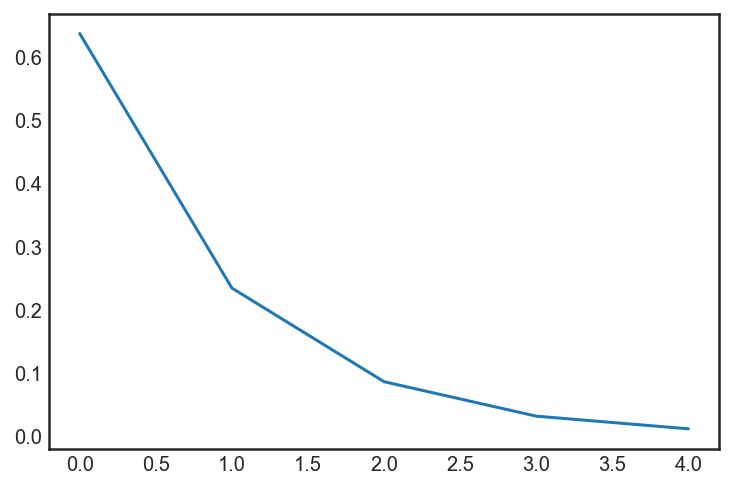

In [211]:
def get_chord_name(x,embedding, random=True):
    if random:
#         indexes = np.arange(5)
#         probs = -np.exp(indexes)
#         probs = np.flip(probs)/sum(probs)
#         index = np.random.choice(np.arange(5), size=1, p=probs)[0]
        index = np.random.randint(5)
    else:
        index = 0
    return embedding.wv.most_similar(x.reshape(1,-1))[index][0]

In [212]:
def print_example_predictions(model, X_test, y_test, embedding):
    for i in range(20):
        x_test_ex = X_test[i]
        y_pred = model.predict(x_test_ex[np.newaxis, :])
        print(get_chord_name(x_test_ex[-3],embedding,random=False), end="\t")
        print(get_chord_name(x_test_ex[-2],embedding,random=False), end="\t")
        print(get_chord_name(x_test_ex[-1],embedding,random=False), end="\t")
        print("(", get_chord_name(y_test[i],embedding,random=False), end=")\t", sep="")
        most_sim = [d[0] for d in embedding.wv.most_similar(y_pred)][:5]
        print("[",end="")
        print(*most_sim,"]", sep="\t")
        
print_example_predictions(model, X_test, y_test, embedding)

G7b9	D7b13	A7b9#9	(Bb^7)	[A7b9	D-^7	D-6	D-b6	G7#11	]
Db7#11	Ah7	D7b13	(G7b9#9)	[D-^7	D-b6	G7#11	D-6	B7#11	]
Ao7	F13	Ao7	(Eb7#11)	[G7#11	D-^7	B7#11	D-b6	D-6	]
B7#11	G9#5	G9	(Dbo7)	[D-6	Db7#9	B9	B13	D-^7	]
G7b9#9	Eb6	G7b9#9	(F13)	[D-^7	D-6	D-b6	G7#11	A7b9	]
C9	A7b9b13	G9#5	(A7b9#9)	[D-6	D-^7	D-b6	D-#5	D-	]
Eh7	G9#5	G13	(Eh7)	[D-^7	Eb-^7	D-6	Db7#9	G7#11	]
Abo7	Bb^7	Eh7	(F7#5)	[D-^7	D-6	Eb-^7	B7b5	Ab7b9#5	]
A7b9b13	G-#5	A7b9#9	(E7#11)	[D-^7	D-6	D-b6	D-#5	Ebh	]
G7b9#5	Bb^	A7b9b13	(E7#11)	[D-^7	D-6	D-b6	D-#5	A7b9	]
G9	G9#5	D7b9#9	(D-7)	[D-^7	D-6	D-b6	D-#5	Ebh	]
Eh7	C7#5	E7b9b13	(G7b13)	[Eb-^7	Db7#9	D-^7	B7#11	Ab7b9#5	]
G7b9#9	E7b5	F13	(G7b9#9)	[D-^7	Eb-^7	G7#11	Db-^7	A7b9	]
A7b9#9	G-#5	A7b9#9	(Eb6)	[D-^7	D-6	D-b6	D-#5	Ebh	]
F13	G7b9#9	D7b13	(D7b13)	[D-6	D-^7	D-b6	B7b5	A7b9	]
Eh7	G9#5	G9	(C69)	[D-6	D-^7	D-b6	A7b9	D-#5	]
E13	A7b9#9	D13	(Eb6)	[D-6	Db7#9	D-^7	B9	G9#11	]
D7#5	G-69	A7b9b13	(G-69)	[D-^7	G7#11	D-b6	D-6	B7#11	]
F^7	F^7	F^7	(F^7)	[D-6	D-^7	D-b6	Db7#9	Ab7b9#5	]
D7b13	A7b9#9	E7#11	(A13)

In [219]:
def get_song_meta(index):
    meta = SONG_TITLES.iloc[index]
    print(f"Song No: {index}/{len(SONG_TITLES)}\nTitle: {meta.title}\nComposer: {meta.composer}\n{meta.style} in {meta.key}")
    
def pretty_print_song(song, input_seq_len):
    print("\n","-"*29, "ORIGINAL SONG", '-'*29)
    for i, c in enumerate(song):
        if i%4 == 0:
            print("\n" +str(i), end=':\t\t')
        if i == input_seq_len-1:
            print(c, end="\t||\t")
            print("\n\n","-"*29, "AI GENERATION", '-'*29)
        else:
            print(c, end="\t|\t")
    print("")
def generate_song(init_seq, length, embedding, model, index=None):
    i = index or np.random.randint(len(songs))
    get_song_meta(i)
    init_seq = init_seq[i]
#     input_seq_len = model._feed_input_shapes[0][1]
    input_seq_len = 16
    init_seq = init_seq[:input_seq_len]
    sample = embedding.wv[init_seq]
    song = init_seq
    for i in range(length-sample.shape[0]):
        next_chord = model.predict(sample[-input_seq_len:][np.newaxis, :], verbose=0)
        sample = np.vstack([sample,next_chord])
    generated_song = [get_chord_name(chord,embedding) for chord in sample[input_seq_len:]]
    song = song + generated_song
    pretty_print_song(song, input_seq_len)
    print(*generated_song, sep=",")

In [220]:
for index in range(1,10):
    generate_song(songs, 32, embedding, model, index)
    print("\n\n\n\n")

Song No: 1/2137
Title: 'Tain't No Sin To Take Off Your Skin
Composer: Walter Donaldson, Edgar Leslie (1929)
Medium Swing in Eb

 ----------------------------- ORIGINAL SONG -----------------------------

0:		Eb	|	Bb7	|	Eb	|	Bb7	|	
4:		Eb	|	F7	|	Bb7	|	Eb	|	
8:		Ab	|	Eb	|	Bb7	|	Eb	|	
12:		Bb7	|	Eb	|	Bb7	|	Eb	||	

 ----------------------------- AI GENERATION -----------------------------

16:		Eo	|	Ebh7	|	Fo	|	Ebh	|	
20:		Ebh	|	Db-	|	Ebh	|	Eb-7b5	|	
24:		Eo	|	Db-	|	Ebh	|	Ebh	|	
28:		Eb-7b5	|	Eo	|	Ebh7	|	Eo	|	
Eo,Ebh7,Fo,Ebh,Ebh,Db-,Ebh,Eb-7b5,Eo,Db-,Ebh,Ebh,Eb-7b5,Eo,Ebh7,Eo





Song No: 2/2137
Title: 'Tain't What You Do (It's The Way That Cha Do It)
Composer: Sy Oliver, Trummy Young (1939)
Medium Swing in Bb

 ----------------------------- ORIGINAL SONG -----------------------------

0:		Bb	|	Bb7	|	Eb	|	Gb7	|	
4:		Bb	|	Bo	|	C-7	|	F7	|	
8:		Bb	|	Bb7	|	Eb	|	Eb-	|	
12:		Bb	|	F7	|	Bb	|	Bb7	||	

 ----------------------------- AI GENERATION -----------------------------

16:		Ebh	|	Fo	|	D-6	|